In [40]:
import pandas as pd 
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import plotly.express as px
from functions.common_functions import *

In [41]:
df = pd.read_csv('../data/processed/mannich_reaction_descriptors.csv')

In [42]:
## Initial Processing ##

vt = VarianceThreshold()

parameters = df.iloc[:,4:] ## Set parameters to desired columns ##
thres = vt.fit(parameters)
parameters = thres.transform(parameters)

scaled_data = StandardScaler().fit_transform(parameters)

In [43]:
## Elbow Plot ##

num_reactions = len(df)

reducer = umap.UMAP(
    random_state=25,
    min_dist=0,  # Default is 0.1
    n_neighbors=num_reactions-1,  # Default is 15
    n_components=10)

clustering_embedding = reducer.fit_transform(scaled_data)

range_, inertia = get_clusters(clustering_embedding,50)


In [44]:
## Get Cluster Labels ##

labels = k_cluster(clustering_embedding,11)
rxn_cluster_df = pd.DataFrame({'Reaction':df['Reaction'],'cluster_label':labels})


In [45]:
## Merge labels to full dataset ##

full_df = pd.read_csv('../data/processed/mannich_database_processed.csv')
full_df_trim = full_df.loc[:,['Reaction','Catalyst_Type','ee']]
full_df_clusters = pd.merge(full_df_trim,rxn_cluster_df,how='inner',on='Reaction')

In [46]:
import json
measurments = json.load(open("param3.json"))
def calculate_quadrant_statistics(entry):
    name, dict1, dict2 = entry

    values1 = []
    values2 = []
    above_count=0
    above_count2=0
    for quadrant in dict1.keys():
        values1.append(dict1[quadrant])
        values2.append(dict2[quadrant])
        if dict1[quadrant] > 10:
            above_count+=1
        if dict2[quadrant] > 10:
            above_count2+=1
        

        # Calculate summary statistics for the differences
    mean_occupancy = np.mean(values1)
    std = np.std(values1)


    mean_ray_pass = np.mean(values2)
    std_ray_pass = np.std(values2)

    quadrant_statistics2 ={
            'Name': name,
            'Mean_occupancy': mean_occupancy,
            'exceeded_count': above_count,
            'Std_occupancy': std,
            'Mean_pass': mean_ray_pass,
            'exceeded_ray_count': above_count2,
            'Std_pass': std_ray_pass,
        }

    return quadrant_statistics2

# List to store the results
results = []


# Iterate through the data_list and calculate statistics for each name and quadrant
for entry in measurments:
    quadrant_stats = calculate_quadrant_statistics(entry)
    results.append(quadrant_stats)

In [47]:
df_ee = pd.read_csv("../data/processed/mannich_database_processed.csv")

df = pd.DataFrame.from_dict(results, orient='columns')
df = df.reset_index()
df = df.sort_values(by='Mean_occupancy', ascending=True)

CT=pd.DataFrame()
CT["Catalyst_Type"]=df_ee["Catalyst_Type"]
CT["Name"]=df_ee["Imine_SMILES"]
CT=CT.drop_duplicates()
#CT = df_ee.groupby('Name')
df['Count'] = df.groupby('Name')['Mean_occupancy'].transform('count')
average_ee_by_name = df_ee.groupby('Imine_SMILES')['ee'].mean().reset_index()
max_ee_by_name = df_ee.groupby(['Imine_SMILES',"Catalyst_Type"])['ee'].max().reset_index()
max_ee_by_name = max_ee_by_name.loc[max_ee_by_name.groupby('Imine_SMILES')['ee'].idxmax()]

df_ee['yield'] = pd.to_numeric(df_ee['yield'], errors='coerce')
average_yield_by_name = df_ee.groupby('Imine_SMILES')['yield'].mean().reset_index()
max_yield_by_name = df_ee.groupby('Imine_SMILES')['yield'].max().reset_index()

average_ee_by_name = average_ee_by_name.rename(columns={'Imine_SMILES': 'Name'})

max_yield_by_name = max_yield_by_name.rename(columns={'Imine_SMILES': 'Name'})
max_yield_by_name = max_yield_by_name.rename(columns={'yield': 'yield_max'})

max_ee_by_name = max_ee_by_name.rename(columns={'Imine_SMILES': 'Name'})
max_ee_by_name = max_ee_by_name.rename(columns={'ee': 'ee_max'})
average_yield_by_name = average_yield_by_name.rename(columns={'Imine_SMILES': 'Name'})

# Match the 'ee' column with the 'Experiment' column in your DataFrame based on name
df = pd.merge(df, average_ee_by_name, how='left', on='Name')
df = pd.merge(df, average_yield_by_name, how='left', on='Name')
df = pd.merge(df, max_yield_by_name, how='left', on='Name')
df = pd.merge(df, max_ee_by_name, how='left', on='Name')

In [48]:
import rdkit
from rdkit.Chem import AllChem

my_elements = {6: "C", 8: "O", 1: "H", 16: "S", 7: "N", 15: "P", 9:"F", 14: "Si", 17:"Cl"}


def gen_smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    if m is None: 
        return None
    else:
        m = rdkit.Chem.AddHs(m)
        order_string = {
            rdkit.Chem.rdchem.BondType.SINGLE: 1,
            rdkit.Chem.rdchem.BondType.DOUBLE: 2,
            rdkit.Chem.rdchem.BondType.TRIPLE: 3,
            rdkit.Chem.rdchem.BondType.AROMATIC: 4,
        }
        N = len(list(m.GetAtoms()))
        nodes = np.zeros((N, len(my_elements)))
        lookup = list(my_elements.keys())
        for i in m.GetAtoms():
            nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

        adj = np.zeros((N, N))
        for j in m.GetBonds():
            u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
            v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
            order = j.GetBondType()
            if order in order_string:
                order = order_string[order]
            else:
                raise Warning("Ignoring bond order" + order)
            adj[u, v] = 1
            adj[v, u] = 1
        adj += np.eye(N)
        return nodes, adj

def smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N, 5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v, order] = 1
        adj[v, u, order] = 1
    return nodes, adj

def example():
    for i in range(len(full_df)):
        graph = gen_smiles2graph(full_df.Catalyst[i])
        
        if graph is None: continue
        sol = full_df.ee[i]
        yield graph, sol




def mol_to_nx(mol):
    G = nx.Graph()
    
    AllChem.EmbedMolecule(mol)
    #mol.GetConformer(0)
    for i, atom in enumerate(mol.GetAtoms()):
        G.add_node(atom.GetIdx(),
                   #atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol(),
                   atom_chiral=atom.GetChiralTag(),
                   atom_degree=atom.GetDegree(),
                   #position=mol.GetConformer().GetAtomPosition(i)
                   )
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
        
    return G


def make_graph(sml):
    mol = Chem.MolFromSmiles(sml)
    G = mol_to_nx(mol)

    return G
nodes, adj = smiles2graph("CO")

nodes, adj = gen_smiles2graph("CO")
adj_mat = np.sum(adj, axis=-1) + np.eye(adj.shape[0])



In [49]:
all_graphs = []
all_nodes = []
import networkx as nx

for i in range(len(full_df)):
        node, adj = gen_smiles2graph(full_df.Catalyst[i])   
        if node is None: continue
        all_graphs.append(nx.from_numpy_array(adj))
        all_nodes.append(node)
        


In [50]:
max_ee_by_name = df_ee.groupby(["Catalyst",'Imine_SMILES'])['ee'].max().reset_index()
max_ee_by_name
#mean_rank = df_ee.groupby(['Catalyst'])['ee_max'].mean()


,Catalyst,Imine_SMILES,ee
0,C1CN[C@H](CN2CCCC2)C1,CCOC(=O)/C=N/c1ccc(OC)cc1,57.0
1,C1CN[C@H](CN2CCCC2)C1,CCOC(=O)c1nc(=O)oc2c1ccc1ccccc12,84.0
2,C1CN[C@H](CN2CCCC2)C1,CCOC(=O)c1nc(=O)oc2cc(OC)ccc12,87.0
3,C1CN[C@H](CN2CCCC2)C1,CCOC(=O)c1nc(=O)oc2ccc(C)cc12,89.0
4,C1CN[C@H](CN2CCCC2)C1,CCOC(=O)c1nc(=O)oc2ccc(F)cc12,83.0
...,...,...,...
1289,OC[C@@H]1CCCN1,CCOC(=O)/C=N/c1ccc(OC)cc1,60.0
1290,O[C@@H]1CCNC1,CCOC(=O)/C=N/c1ccc(OC)cc1,20.0
1291,O[C@H]1Cc2ccccc2[C@@H]1NC(=S)Nc1cc(C(F)(F)F)cc...,CC(C)(C)OC(=O)/N=C/c1cccc(Cl)c1,25.0
1292,Oc1c(-c2c(-c3ccccc3)cc3ccc4ccccc4c3c2O)c(-c2cc...,COC(=O)C1=Nc2ccccc2C1=O,20.0


In [51]:
cat_graphs = []
catlabels = []
import networkx as nx
cat_uniq = np.unique(full_df.Catalyst)
for i in range(len(cat_uniq)):
        adj = make_graph(cat_uniq[i])
        k=full_df.loc[full_df["Catalyst"]==cat_uniq[i]]["Catalyst_Type"].values[0]
        cat_graphs.append(adj)
        catlabels.append(k)



sub_uniq = np.unique(df_ee.Imine_SMILES)
sub_graphs = []
ee=[]
for i in range(len(sub_uniq)):
        k=np.mean(df.loc[df["Name"]==sub_uniq[i]]["ee_max"].values)
        if k == k:
                adj = make_graph(sub_uniq[i])
                sub_graphs.append(adj)
                ee.append(k)

ee_cat=[]
for i in range(len(cat_uniq)):
        k=np.mean(max_ee_by_name.loc[max_ee_by_name["Catalyst"]==cat_uniq[i]]["ee"].values)
        if k == k:
                
                ee_cat.append(k)


[15:39:20] Molecule does not have explicit Hs. Consider calling AddHs()
[15:39:20] Molecule does not have explicit Hs. Consider calling AddHs()
[15:39:20] Molecule does not have explicit Hs. Consider calling AddHs()
[15:39:20] Molecule does not have explicit Hs. Consider calling AddHs()
[15:39:20] Molecule does not have explicit Hs. Consider calling AddHs()
[15:39:20] Molecule does not have explicit Hs. Consider calling AddHs()
[15:39:20] Molecule does not have explicit Hs. Consider calling AddHs()
[15:39:20] Molecule does not have explicit Hs. Consider calling AddHs()
[15:39:20] Molecule does not have explicit Hs. Consider calling AddHs()
[15:39:20] Molecule does not have explicit Hs. Consider calling AddHs()
[15:39:20] Molecule does not have explicit Hs. Consider calling AddHs()
[15:39:20] Molecule does not have explicit Hs. Consider calling AddHs()
[15:39:20] Molecule does not have explicit Hs. Consider calling AddHs()
[15:39:20] Molecule does not have explicit Hs. Consider calling 

In [52]:
len(np.unique(df_ee.Imine_SMILES))

500

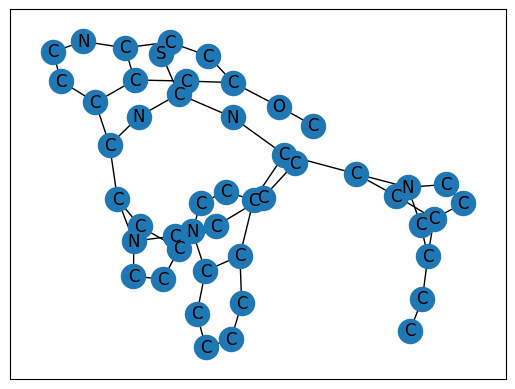

In [53]:
molecule = cat_graphs[20]
def draw_mol_graph(molecule):
    elements = nx.get_node_attributes(molecule, 'atom_symbol')
    position = nx.get_node_attributes(molecule, 'position')

    color_map = {'C': 'cyan',
                'O': 'orange',
                'N': 'magenta'}  
    #nx.draw(graphs[0])

    nx.draw_networkx(molecule, pos=nx.spring_layout(molecule), with_labels=True, labels = elements)

draw_mol_graph(molecule)

In [54]:

def find_properties(sub_graphs, node_prop="N", node_prop_name="atom_symbol", edge_prop="DOUBLE",edge_prop_name="bond_type"):
    atom_candidates = []
    num_atom_candidateds = [] 
    for mol in sub_graphs:
        selected_nodes = [node for node, data in mol.nodes(data=True) if data.get(node_prop_name) == node_prop]
        #print(len(selected_nodes) , selected_nodes)
        nodes_with_target_edge = []

        for node in selected_nodes:
            for neighbor in mol.neighbors(node):
                edge_data = mol.get_edge_data(node, neighbor)
                if  str(edge_data.get(edge_prop_name)) == edge_prop:
                    
                    nodes_with_target_edge.append(node)
                    #print(nodes_with_target_edge)
        atom_candidates.append(nodes_with_target_edge)
        num_atom_candidateds.append(len(nodes_with_target_edge))
    return atom_candidates, num_atom_candidateds
atom_candidates, num_atom_candidateds = find_properties(sub_graphs)

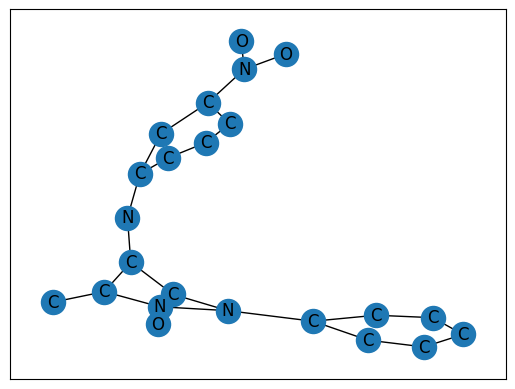

In [55]:
draw_mol_graph(sub_graphs[np.argmax(num_atom_candidateds)])

In [56]:


#nx.graph_edit_distance(graphs[0],graphs[1])

"""edit_matrix = np.zeros([len(graphs),len(graphs)])
for i in range(len(graphs)):
    print(i)
    for j in range(len(graphs)):
        if j < i:
            edit_matrix[i,j] = nx.graph_edit_distance(graphs[i],graphs[j])
            edit_matrix[j,i] = edit_matrix[i,j]"""

'edit_matrix = np.zeros([len(graphs),len(graphs)])\nfor i in range(len(graphs)):\n    print(i)\n    for j in range(len(graphs)):\n        if j < i:\n            edit_matrix[i,j] = nx.graph_edit_distance(graphs[i],graphs[j])\n            edit_matrix[j,i] = edit_matrix[i,j]'

In [57]:
# import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx

def graph_grid_plot(G):
    Num_nodes = len(G.nodes)

    # plt.figure(figsize=(5,5))
    edges = G.edges()

    # ## update to 3d dimension
    spring_3D = nx.spring_layout(G, dim = 3, k = 0.5) # k regulates the distance between nodes
    # weights = [G[u][v]['weight'] for u,v in edges]
    # nx.draw(G, with_labels=True, node_color='skyblue', font_weight='bold',  width=weights, pos=pos)

    # we need to seperate the X,Y,Z coordinates for Plotly
    # NOTE: spring_3D is a dictionary where the keys are 1,...,6
    x_nodes= [spring_3D[key][0] for key in spring_3D.keys()] # x-coordinates of nodes
    y_nodes = [spring_3D[key][1] for key in spring_3D.keys()] # y-coordinates
    z_nodes = [spring_3D[key][2] for key in spring_3D.keys()] # z-coordinates

    #we need to create lists that contain the starting and ending coordinates of each edge.
    x_edges=[]
    y_edges=[]
    z_edges=[]

    #create lists holding midpoints that we will use to anchor text
    xtp = []
    ytp = []
    ztp = []

    #need to fill these with all of the coordinates
    for edge in edges:
        #format: [beginning,ending,None]
        x_coords = [spring_3D[edge[0]][0],spring_3D[edge[1]][0],None]
        x_edges += x_coords
        xtp.append(0.5*(spring_3D[edge[0]][0]+ spring_3D[edge[1]][0]))

        y_coords = [spring_3D[edge[0]][1],spring_3D[edge[1]][1],None]
        y_edges += y_coords
        ytp.append(0.5*(spring_3D[edge[0]][1]+ spring_3D[edge[1]][1]))

        z_coords = [spring_3D[edge[0]][2],spring_3D[edge[1]][2],None]
        z_edges += z_coords
        ztp.append(0.5*(spring_3D[edge[0]][2]+ spring_3D[edge[1]][2])) 


    #etext = [f'weight={w}' for w in edge_weights]

    trace_weights = go.Scatter3d(x=xtp, y=ytp, z=ztp,
        mode='markers',
        marker =dict(color='rgb(125,125,125)', size=1), #set the same color as for the edge lines
        )

    #create a trace for the edges
    trace_edges = go.Scatter3d(
        x=x_edges,
        y=y_edges,
        z=z_edges,
        mode='lines',
        line=dict(color='black', width=2),
        hoverinfo='none')

    #create a trace for the nodes
    trace_nodes = go.Scatter3d(
        x=x_nodes,
        y=y_nodes,
        z=z_nodes,
        mode='markers',
        marker=dict(symbol='circle',
                size=10,
                color='skyblue')
        )

    #Include the traces we want to plot and create a figure
    data = [trace_edges, trace_nodes, trace_weights]
    fig = go.Figure(data=data)

    fig.show()

graph_grid_plot(cat_graphs[10])


In [58]:
from grakel import GraphKernel
from sklearn.cluster import AgglomerativeClustering
from grakel.utils import graph_from_networkx

# Generate a list of NetworkX graphs (replace with your graphs)
graphs = [nx.Graph(), nx.Graph(), nx.Graph()]  # Add your graphs here

# Create a list of graph labels (you can use integers as labels)
labels = [0, 1, 2]  # Assign labels to your graphs

# Convert NetworkX graphs to a format compatible with grakel
graph_list = []
Gs = graph_from_networkx(sub_graphs,node_labels_tag='atom_symbol')

#Gs = graph_from_networkx(cat_graphs)
for G in graphs:
    G = nx.Graph(G)
    # Convert NetworkX graph to a dictionary representation
    graph_dict = nx.to_dict_of_lists(G)
    graph_list.append(graph_dict)

# Create a graph kernel (Weisfeiler-Lehman subtree kernel)
kernel = GraphKernel(kernel={"name": "weisfeiler_lehman", "n_iter": 100})

# Compute the kernel matrix
kernel_matrix = kernel.fit_transform(Gs)

# Perform hierarchical clustering on the kernel matrix
n_clusters = 3 # Number of clusters to create
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
cluster_labels = clustering.fit_predict(kernel_matrix)

# Group graphs based on cluster labels
graph_clusters = [[] for _ in range(n_clusters)]
for i, cluster_label in enumerate(cluster_labels):
    graph_clusters[cluster_label].append(sub_graphs[i])

# Print the resulting graph clusters
for cluster_id, cluster in enumerate(graph_clusters):
    print(f"Cluster {cluster_id + 1}:")
    #for i, G in enumerate(cluster):
        #print(f"Graph {i + 1} (Label: {sub_uniq[i]}):")


Cluster 1:
Cluster 2:
Cluster 3:


In [59]:

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from grakel.kernels import CoreFramework
from grakel.datasets import fetch_dataset
from grakel.kernels import PropagationAttr
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from grakel.kernels import ShortestPath

G = graph_from_networkx(sub_graphs, node_labels_tag='atomic_num')
label_ee = []
for e in ee:
    if e < 70:
        label_ee.append(0)
    else:
        label_ee.append(1)

G_train, G_test, y_train, y_test = train_test_split(sub_graphs, label_ee, test_size=0.2, random_state=42)

"""G_train =Gs[:-50]
G_test=Gs[:-50]"""
# Uses the graphhopper kernel to generate the kernel matrices
G_test = graph_from_networkx(G_test, node_labels_tag='atom_symbol')
G_train = graph_from_networkx(G_train, node_labels_tag='atom_symbol')

#gk = PropagationAttr(normalize=True)
#gk = CoreFramework(normalize=True)
gk = GraphKernel(kernel={"name": "weisfeiler_lehman"})
#gk = WeisfeilerLehman(n_iter=40, base_graph_kernel=VertexHistogram, normalize=True)
#gk = ShortestPath(normalize=True, with_labels=False)

K_train = gk.fit_transform(G_train)
K_test = gk.transform(G_test)

# Uses the SVM classifier to perform classification
clf = SVC(kernel="precomputed",C=0.1)
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

# Computes and prints the classification accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Print the metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-Score: {f1 * 100:.2f}%')
print('Confusion Matrix:')
print(confusion)


Accuracy: 91.00%
Precision: 94.79%
Recall: 95.79%
F1-Score: 95.29%
Confusion Matrix:
[[ 0  5]
 [ 4 91]]


In [60]:
from grakel.utils import cross_validate_Kfold_SVM
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
svc = SVC()

# Define a grid of hyperparameters to search over
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly','precomputed'],  # Kernel type
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(K_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best SVM classifier
best_svc = grid_search.best_estimator_

# Evaluate the best SVM classifier on the test data
accuracy = best_svc.score(K_test, y_test)
print(f"Test Accuracy with Best Model: {accuracy * 100:.2f}%")


Best Hyperparameters: {'C': 1, 'kernel': 'poly'}
Test Accuracy with Best Model: 95.00%


In [61]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100,max_depth=None , min_samples_split=2,min_samples_leaf=4,max_features='log2',random_state=42)

# Train the classifier on the training data
rf_classifier.fit(K_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(K_test)

accuracy = accuracy_score(y_test, y_pred)
# Calculate precision
precision = precision_score(y_test, y_pred, pos_label="high")

# Calculate recall
recall = recall_score(y_test, y_pred, pos_label="high")

# Calculate F1-score
f1 = f1_score(y_test, y_pred, pos_label="high")

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred, labels=["low", "high"])

# Print the metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-Score: {f1 * 100:.2f}%')
print('Confusion Matrix:')
print(confusion)

ValueError: pos_label=high is not a valid label. It should be one of [0, 1]

In [62]:
rf_classifier = RandomForestClassifier(random_state=42)

# Define a grid of hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt', 'log2']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring="recall")

# Perform the grid search on the training data
grid_search.fit(K_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best Random Forest classifier
best_rf_classifier = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_rf_classifier.predict(K_test)

# Calculate accuracy with the best model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy with Best Model: {accuracy * 100:.2f}%')
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Test Accuracy with Best Model: 95.00%
[[ 0  5]
 [ 0 95]]


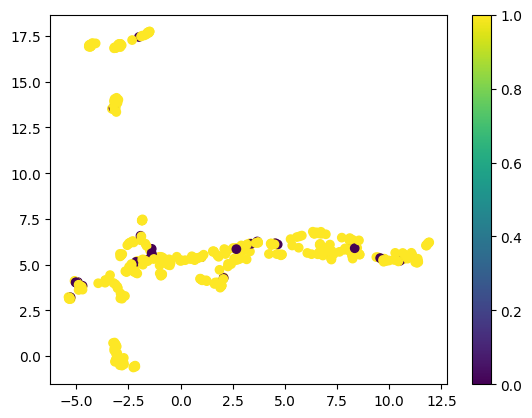

In [63]:
reducer = umap.UMAP()
lower_dimensional_representation = reducer.fit_transform(K_train)
import matplotlib.pyplot as plt

# Assuming 'labels' contains your data point labels or classes (optional)
plt.scatter(lower_dimensional_representation[:, 0], lower_dimensional_representation[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.show()

/home/user/Desktop/MS/env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/home/user/Desktop/MS/env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



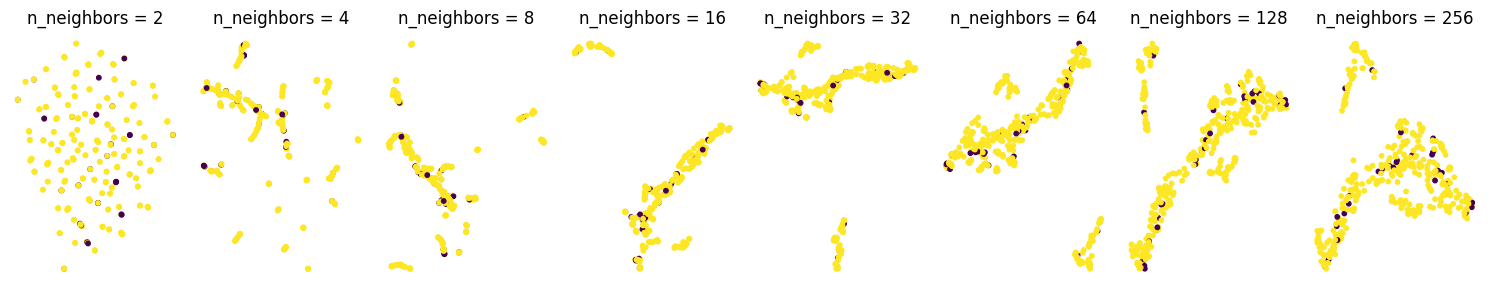

In [64]:

# Define a range of neighbor values to test
n_neighbors_values = [2, 4, 8, 16, 32, 64, 128, 256]

# Create subplots for each value of n_neighbors
fig, axes = plt.subplots(1, len(n_neighbors_values), figsize=(15, 3))

for i, n_neighbors in enumerate(n_neighbors_values):
    # Apply UMAP with the current number of neighbors
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    lower_dimensional_representation = reducer.fit_transform(K_train)
    
    # Plot the results in a scatter plot
    ax = axes[i]
    ax.scatter(lower_dimensional_representation[:, 0], lower_dimensional_representation[:, 1], s=10, c=y_train, cmap='viridis')
    ax.set_title(f'n_neighbors = {n_neighbors}')
    ax.axis('off')

plt.tight_layout()
plt.show()

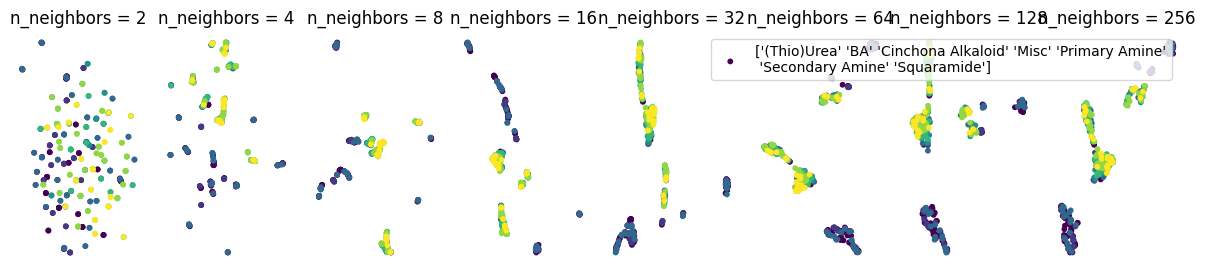

In [65]:
G = graph_from_networkx(cat_graphs , node_labels_tag='atom_symbol',edge_labels_tag=)
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol(),
                   atom_chiral=atom.GetChiralTag(),
                   atom_degree
#gk = PropagationAttr(normalize=True)
#gk = CoreFramework(normalize=True)
gk = GraphKernel(kernel={"name": "weisfeiler_lehman"}, normalize=True)
#gk = WeisfeilerLehman(n_iter=40, base_graph_kernel=VertexHistogram, normalize=True)
#gk = ShortestPath(normalize=True, with_labels=False)
uniquec = np.unique(catlabels)
num_CL = []
for j in range(len(uniquec)):
    for i in range(len(catlabels)):
        if catlabels[i] == uniquec[j]:
            num_CL.append(j)


K_train = gk.fit_transform(G)
n_neighbors_values = [2, 4, 8, 16, 32, 64, 128, 256]

# Create subplots for each value of n_neighbors
fig, axes = plt.subplots(1, len(n_neighbors_values), figsize=(15, 3))

for i, n_neighbors in enumerate(n_neighbors_values):
    # Apply UMAP with the current number of neighbors
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    lower_dimensional_representation = reducer.fit_transform(K_train)
    
    # Plot the results in a scatter plot
    ax = axes[i]
    ax.scatter(lower_dimensional_representation[:, 0], lower_dimensional_representation[:, 1], s=10, c=num_CL,label=uniquec, cmap='viridis')

    ax.set_title(f'n_neighbors = {n_neighbors}')
    ax.axis('off')
plt.legend()
#plt.tight_layout()
plt.show()


In [67]:
G = graph_from_networkx(cat_graphs , node_labels_tag='atom_symbol')

reducer = umap.UMAP(n_neighbors=8)
gk = GraphKernel(kernel={"name": "weisfeiler_lehman","n_iter":8}, normalize=True)
#gk = GraphKernel(kernel={"name": "hadamard_code","n_iter":8}, normalize=True)
#gk = GraphKernel(kernel={"name": "core_framework"}, normalize=True)

K_train = gk.fit_transform(G)

lower_dimensional_representation = reducer.fit_transform(K_train)
df = pd.DataFrame()
df['UMAP1'] = lower_dimensional_representation[:, 0]
df['UMAP2'] = lower_dimensional_representation[:, 1]
df['Category'] = catlabels
fig = px.scatter(
            df,
            x='UMAP1',
            y='UMAP2',
            color='Category',
            #color_discrete_sequence=[colormap[i] for i in range(len(df['Category'].unique()))],
        )
fig.show()


In [68]:


df = pd.DataFrame()
df['UMAP1'] = lower_dimensional_representation[:, 0]
df['UMAP2'] = lower_dimensional_representation[:, 1]
df['ee'] = ee_cat
fig = px.scatter(
            df,
            x='UMAP1',
            y='UMAP2',
            color='ee',
            #color_discrete_sequence=[colormap[i] for i in range(len(df['Category'].unique()))],
        )
fig.show()

In [69]:
label_ee_cat = []
for e in ee_cat:
    if e < 95:
        label_ee_cat.append("low ee")
    else:
        label_ee_cat.append("High ee")

df = pd.DataFrame()
df['UMAP1'] = lower_dimensional_representation[:, 0]
df['UMAP2'] = lower_dimensional_representation[:, 1]
df['ee'] = label_ee_cat
fig = px.scatter(
            df,
            x='UMAP1',
            y='UMAP2',
            color='ee',
            #color_discrete_sequence=[colormap[i] for i in range(len(df['Category'].unique()))],
        )
fig.show()


In [70]:
mean_rank

NameError: name 'mean_rank' is not defined

In [71]:
df_ee["rank"] = df_ee.groupby("Reaction")["ee"].rank(method="dense", ascending=False)
mean_rank = df_ee.groupby(['Catalyst'])['rank'].mean()
rank_cat=[]
for i in range(len(cat_uniq)):
        k=mean_rank.loc[mean_rank.index==cat_uniq[i]].values[0]
        if k == k:
                adj = make_graph(sub_uniq[i])
                sub_graphs.append(adj)
                rank_cat.append(k)

df = pd.DataFrame()
df['UMAP1'] = lower_dimensional_representation[:, 0]
df['UMAP2'] = lower_dimensional_representation[:, 1]
df['rank'] = rank_cat
fig = px.scatter(
            df,
            x='UMAP1',
            y='UMAP2',
            color='rank',
            #color_discrete_sequence=[colormap[i] for i in range(len(df['Category'].unique()))],
        )
fig.show()

[15:42:14] Molecule does not have explicit Hs. Consider calling AddHs()
[15:42:14] Molecule does not have explicit Hs. Consider calling AddHs()
[15:42:14] Molecule does not have explicit Hs. Consider calling AddHs()
[15:42:14] Molecule does not have explicit Hs. Consider calling AddHs()
[15:42:14] Molecule does not have explicit Hs. Consider calling AddHs()
[15:42:14] Molecule does not have explicit Hs. Consider calling AddHs()
[15:42:14] Molecule does not have explicit Hs. Consider calling AddHs()
[15:42:14] Molecule does not have explicit Hs. Consider calling AddHs()
[15:42:14] Molecule does not have explicit Hs. Consider calling AddHs()
[15:42:14] Molecule does not have explicit Hs. Consider calling AddHs()
[15:42:14] Molecule does not have explicit Hs. Consider calling AddHs()
[15:42:14] Molecule does not have explicit Hs. Consider calling AddHs()
[15:42:14] Molecule does not have explicit Hs. Consider calling AddHs()
[15:42:14] Molecule does not have explicit Hs. Consider calling 

In [457]:

G_train = graph_from_networkx(sub_graphs, node_labels_tag='atom_symbol',edge_labels_tag="bond_type")

gk = PropagationAttr(normalize=True)
#gk = CoreFramework(normalize=True)
#gk = GraphKernel(kernel={"name": "weisfeiler_lehman"})
gk = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)
#gk = ShortestPath(normalize=True, with_labels=False)
#gk = GraphKernel(kernel={"name": "hadamard_code","n_iter":16}, normalize=True)
K_train = gk.fit_transform(G_train)

In [478]:
G1 = nx.Graph()
Kmin=np.min(K_train)
Kmax=np.max(K_train)
for i in range(len(cat_uniq)):
    G1.add_node(cat_uniq[i], pKi=ee_cat[i])
    for j in range(i,len(cat_uniq)):
        if i!=j:
            standardized = (K_train[i,j]-Kmin)/(Kmax-Kmin)
            if standardized>0.85:
               G1.add_edge(cat_uniq[i], cat_uniq[j], weight=standardized)

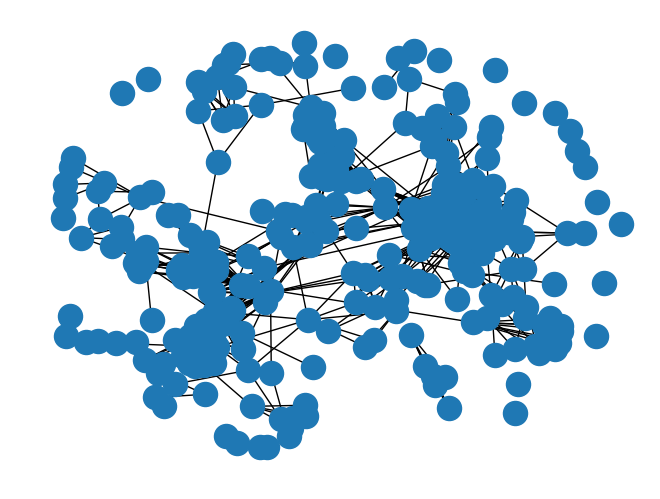

In [479]:
pos = nx.spring_layout(G1, k=0.2,seed=40) # added a seed for layout reproducibility, k is space between nodes
nx.draw(G1,pos)
plt.axis("off")
plt.show()

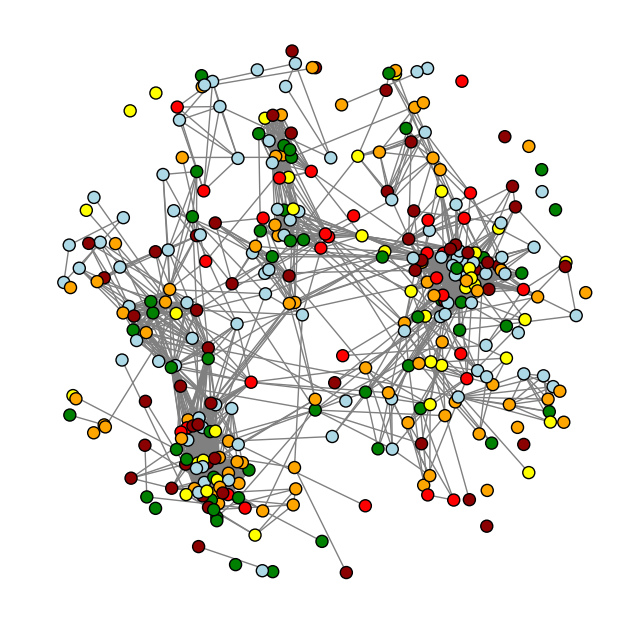

In [480]:

from matplotlib import colors

color_map = []
for node in G1.nodes(data=True):
    if 0<= node[1]["pKi"] <= 30:
        color_map.append("darkred")
    elif 30 < node[1]["pKi"] <= 50:
        color_map.append("red")
    elif 50 < node[1]["pKi"] <= 70:
        color_map.append("orange")
    elif 70 < node[1]["pKi"] <= 80:
        color_map.append("yellow")
    elif 80 < node[1]["pKi"] <= 90:
        color_map.append("green")
    elif 90 < node[1]["pKi"] <= 100:
        color_map.append("lightblue")
    else:
        color_map.append("white")

pos = nx.spring_layout(G1, k=0.3, seed=40) # added a seed for layout reproducibility
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw_networkx_nodes(G1, pos, node_size=75, node_color=color_map, edgecolors="black")
nx.draw_networkx_edges(G1, pos, edge_color="grey")
plt.axis("off")
plt.show()      

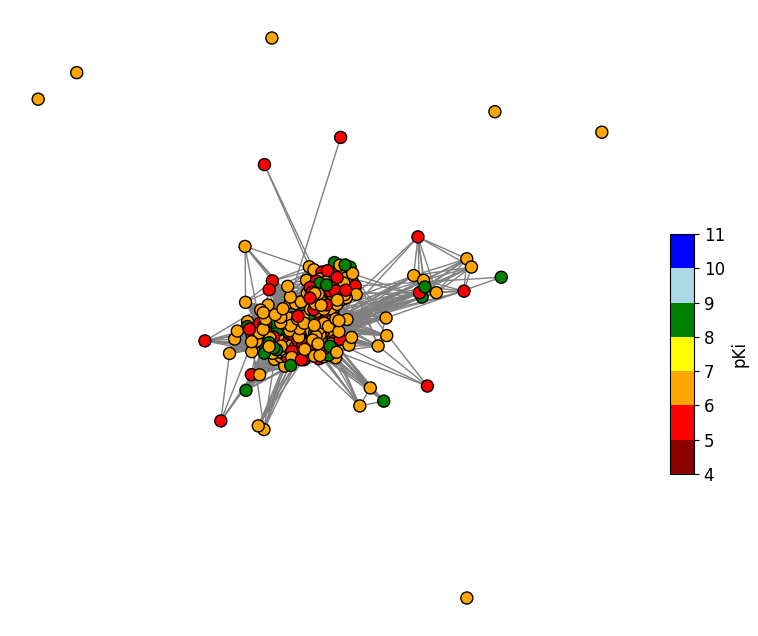

In [188]:

from matplotlib import colors

color_map = []
for node in G1.nodes(data=True):
    if 0 < node[1]["pKi"] <= 50:
        color_map.append("red")
    elif 50 < node[1]["pKi"] <= 95:
        color_map.append("orange")
    elif 95 < node[1]["pKi"] <= 100:
        color_map.append("green")
    else:
        color_map.append("white")

pos = nx.spring_layout(G1, k=0.2, seed=40) # added a seed for layout reproducibility
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw_networkx_nodes(G1, pos, node_size=75, node_color=color_map, edgecolors="black")
nx.draw_networkx_edges(G1, pos, edge_color="grey")
plt.axis("off")

# add legends
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

ax2 = fig.add_axes([0.95, 0.3, 0.03, 0.3]) # distance left, distance up, width size, height size

cmap = (colors.ListedColormap(["darkred","red","orange",
                               "yellow","green","lightblue","blue"]))
bounds = [4, 5, 6, 7, 8, 9, 10, 11]
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='neither',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',

)
cbar.ax.tick_params(labelsize=12)
ax2.set_ylabel('pKi', size=12)
plt.show()

In [481]:
nx.number_connected_components(G1)

43

In [463]:
connected_graphs1 = [G1.subgraph(c).copy() for c in nx.connected_components(G1)]

In [ ]:
H1 = connected_graphs1[1]

fig, ax = plt.subplots()

# Line weights based on similarity value
thick = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] <= 0.7]

# Add color based on pKi and node number labels
custom_labels = {}
color_map = []
label_number = 0
for node in H1.nodes(data=True):
    custom_labels[node[0]] = str(label_number)
    label_number+=1
    if 0 < node[1]["pKi"] <= 50:
        color_map.append("red")
    elif 50 < node[1]["pKi"] <= 70:
        color_map.append("orange")
    elif 70 < node[1]["pKi"] <= 100:
        color_map.append("green")
    else:
        color_map.append("white")

# plot with weights, node color, and labels.
pos = nx.spring_layout(H1, seed=30)
nx.draw_networkx_nodes(H1, pos, ax=ax, node_size=300, node_color=color_map, edgecolors="black")
nx.draw_networkx_labels(H1, pos, custom_labels, ax=ax, font_size=10, font_color="black")
nx.draw_networkx_edges(H1, pos, ax=ax, edgelist=thick, width=3, edge_color="grey")
nx.draw_networkx_edges(H1, pos, ax=ax, edgelist=medium, width=1, edge_color="grey")
nx.draw_networkx_edges(H1, pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="grey", style="dashed")
ax = plt.gca()
plt.axis("off")
plt.tight_layout()


# add legends
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

ax2 = fig.add_axes([0.95, 0.3, 0.03, 0.3]) # distance left, distance up, width size, height size

cmap = (colors.ListedColormap(["darkred","red","orange",
                               "yellow","green","lightblue","blue"]))
bounds = [4, 5, 6, 7, 8, 9, 10, 11]
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='neither',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',

)
cbar.ax.tick_params(labelsize=12)
ax2.set_ylabel('pKi', size=12)

ax3 = fig.add_axes([1.3, 0.55, 0.03, 0.3]) # distance left, distance up, width size, height size
ax3.axis("off")
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="gray", lw=3),
                Line2D([0], [0], color="grey", lw=1),
                Line2D([0], [0], color="grey", lw=1, linestyle='dashed',)]

ax3.legend(custom_lines, ['mcs_similarity >= 0.9', '0.7 < mcs_similarity > 0.9', 'mcs_similarity <= 0.7'],
           loc='best', prop={'size': 10}, fancybox=True, framealpha=0)

plt.savefig('Figure-03_MCS_1_node_lines.png', bbox_inches='tight')
plt.show()

In [483]:
columns = ("Smiles", "ID","pKi")
index = tuple(custom_labels.values())
table_data = []
#label_number = 0
for node in H1.nodes(data=True):
    Smiles = node[0]
    id_value = node[1]
    Ki = node[1]["pKi"]
    table_data.append([Smiles, id_value, Ki])
#    label_number += 1
df_H1 = pd.DataFrame(table_data, columns = columns, index=index)
df_H1
import io
from PIL import Image
def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

(0.5450980392156862, 0.0, 0.0, 1.0)
(1.0, 0.0, 0.0, 1.0)
(1.0, 0.6470588235294118, 0.0, 1.0)
(1.0, 1.0, 0.0, 1.0)
(0.0, 0.5019607843137255, 0.0, 1.0)
(0.6784313725490196, 0.8470588235294118, 0.9019607843137255, 1.0)
(0.0, 0.0, 1.0, 1.0)
(1.0, 1.0, 1.0, 1.0)


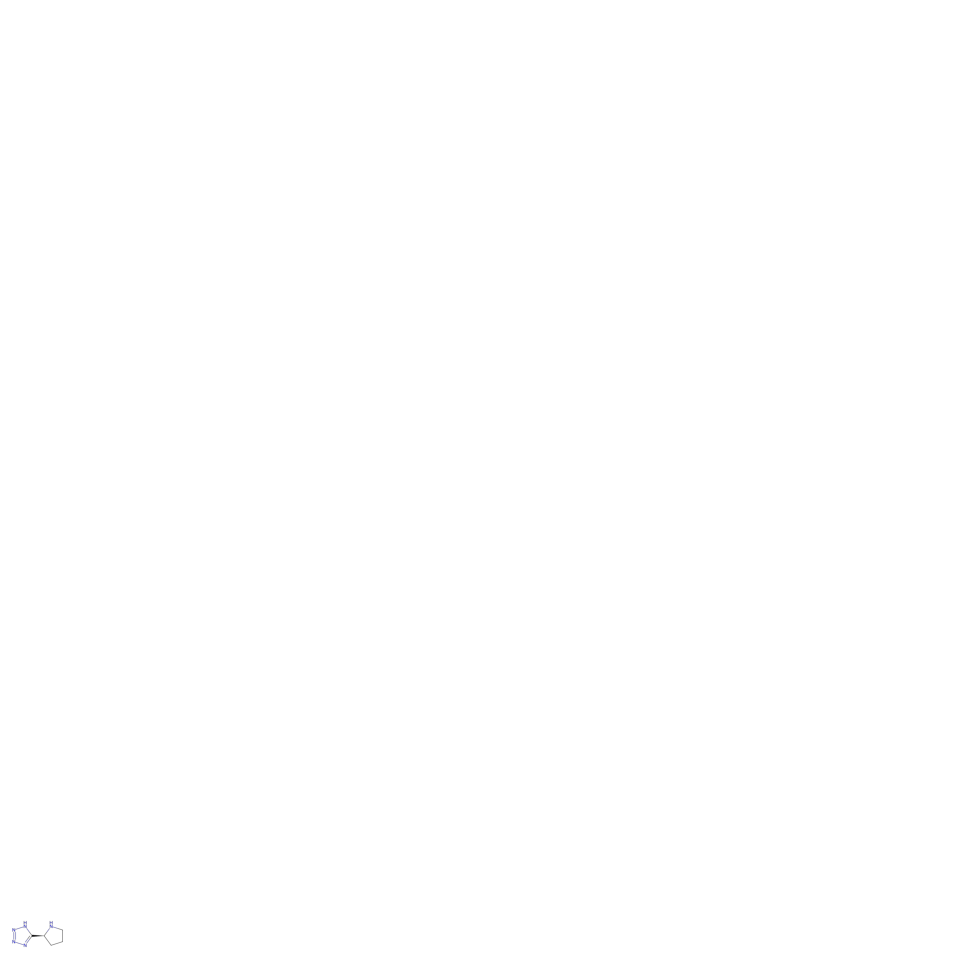

In [134]:
# get some rgba values
from matplotlib import colors
from rdkit.Chem.Draw import rdMolDraw2D

print(colors.to_rgba('darkred'))
print(colors.to_rgba('red'))
print(colors.to_rgba('orange'))
print(colors.to_rgba('yellow'))
print(colors.to_rgba('green'))
print(colors.to_rgba('lightblue'))
print(colors.to_rgba('blue'))
print(colors.to_rgba('white'))
thick = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(H1, seed=30)
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thick, width=3, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=medium, width=1, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax.axis('off')

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
struct_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.045 # adjust this value to change size of structure drawings
struct_center = struct_size / 2.0

# Add the respective image to each node
for smi in H1.nodes:
    
    # draw molecule
    drawer = rdMolDraw2D.MolDraw2DCairo(300,300)
    drawer.drawOptions().clearBackground = False
    drawer.drawOptions().addStereoAnnotation = False
    drawer.DrawMolecule(Chem.MolFromSmiles(smi))
    drawer.FinishDrawing()
    mol = drawer.GetDrawingText()
         
    xf, yf = tr_figure(pos[smi])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot structure
    a = plt.axes([xa - struct_center, ya - struct_center, struct_size, struct_size])
    a.imshow(show_png(mol))
    a.axis("off")
plt.savefig('Figure-04_MCS_1_structures_basic.png', bbox_inches='tight')  
plt.show()

In [ ]:
def highlight_mol(smi,label,color):
    
    mol = Chem.MolFromSmiles(smi)
    
    if color == 'darkred':
        rgba = (0.55, 0.0, 0.0, 0.3)       
    elif color == 'red':
        rgba = (1.0, 0.0, 0.0, 0.2)    
    elif color == 'orange':
        rgba = (1.0, 0.65, 0.0, 0.2)        
    elif color == 'yellow':
        rgba = (1.0, 1.0, 0.0, 0.4)        
    elif color == 'green':
        rgba = (0.0, 0.50, 0.0, 0.15)        
    elif color == 'lightblue':
        rgba = (0.68, 0.85, 0.90, 0.5)   
    elif color == 'blue':
        rgba = (0.0, 0.0, 1.0, 0.1)    
    else: # no color
        rgba = (1,1,1,1) 
             
    atoms = []
    for a in mol.GetAtoms():
        atoms.append(a.GetIdx())
    
    bonds = []
    for bond in mol.GetBonds():
        aid1 = atoms[bond.GetBeginAtomIdx()]
        aid2 = atoms[bond.GetEndAtomIdx()]
        bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())

    drawer = rdMolDraw2D.MolDraw2DCairo(300,300)
    drawer.drawOptions().fillHighlights=True
    drawer.drawOptions().setHighlightColour((rgba))
    drawer.drawOptions().highlightBondWidthMultiplier=15
    drawer.drawOptions().legendFontSize=60
    drawer.drawOptions().clearBackground = False
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, legend=label,highlightAtoms=atoms, highlightBonds=bonds)
    
    mol_png = drawer.GetDrawingText()
    return mol_png
thick = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(H1, seed=30)
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thick, width=3, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=medium, width=1, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax.axis('off')

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
struct_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.044
struct_center = struct_size / 2.0

# Add the respective image to each node

for smi,value in H1.nodes.items():


    if 0 < value["pKi"] <= 50:
        highlight_color = "darkred"

        
    elif 50 < value["pKi"] <= 70:
        highlight_color = "red"
    elif 70 < value["pKi"] <= 85:
        highlight_color = "yellow"
    elif 85 < value["pKi"] <= 100:
        highlight_color = "green"

    else:
        highlight_color = "white"

    xf, yf = tr_figure(pos[smi])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot
    a = plt.axes([xa - struct_center, ya - struct_center, struct_size, struct_size])
    a.imshow(show_png(highlight_mol(smi,str(value["pKi"]), highlight_color)))
    a.axis("off")
         
plt.show()

In [ ]:
thick = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(H1, seed=30)
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thick, width=3, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=medium, width=1, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax.axis('off')

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
struct_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.044
struct_center = struct_size / 2.0

# Add the respective image to each node

for smi,value in H1.nodes.items():


    if 0 < value["pKi"] <= 50:
        highlight_color = "darkred"

        
    elif 50 < value["pKi"] <= 70:
        highlight_color = "red"
    elif 70 < value["pKi"] <= 85:
        highlight_color = "yellow"
    elif 85 < value["pKi"] <= 100:
        highlight_color = "green"

    else:
        highlight_color = "white"

    xf, yf = tr_figure(pos[smi])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot
    a = plt.axes([xa - struct_center, ya - struct_center, struct_size, struct_size])
    a.imshow(show_png(highlight_mol(smi,str(value["pKi"]), highlight_color)))
    a.axis("off")

# add legends
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html
ax2 = fig.add_axes([0.95, 0.3, 0.03, 0.3]) # distance left, distance up, width size, height size

# define our modified colors for the color bar scale
darkred_bar = (0.55, 0.0, 0.0, 0.3)       
red_bar = (1.0, 0.0, 0.0, 0.2)    
orange_bar = (1.0, 0.65, 0.0, 0.2)        
yellow_bar = (1.0, 1.0, 0.0, 0.4)        
green_bar = (0.0, 0.50, 0.0, 0.15)        
lightblue_bar = (0.68, 0.85, 0.90, 0.5)   
blue_bar = (0.0, 0.0, 1.0, 0.1)    

cmap = (colors.ListedColormap([darkred_bar,red_bar,orange_bar,
                               yellow_bar,green_bar,lightblue_bar,blue_bar]))
bounds = [4, 5, 6, 7, 8, 9, 10, 11]
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='neither',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',

)
cbar.ax.tick_params(labelsize=12)
ax2.set_ylabel('pKi', size=12)

ax3 = fig.add_axes([1.1, 0.45, 0.03, 0.3]) # distance left, distance up, width size, height size
ax3.axis("off")
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="lightgray", lw=3),
                Line2D([0], [0], color="lightgrey", lw=1),
                Line2D([0], [0], color="lightgrey", lw=1, linestyle='dashed',)]

ax3.legend(custom_lines, ['mcs_similarity >= 0.9', '0.7 < mcs_similarity > 0.9', 'mcs_similarity <= 0.7'],
           loc='best', prop={'size': 12}, fancybox=True, framealpha=0)
plt.savefig('Figure-05_MCS_1_structures_advanced.png',  bbox_inches='tight')
plt.show()

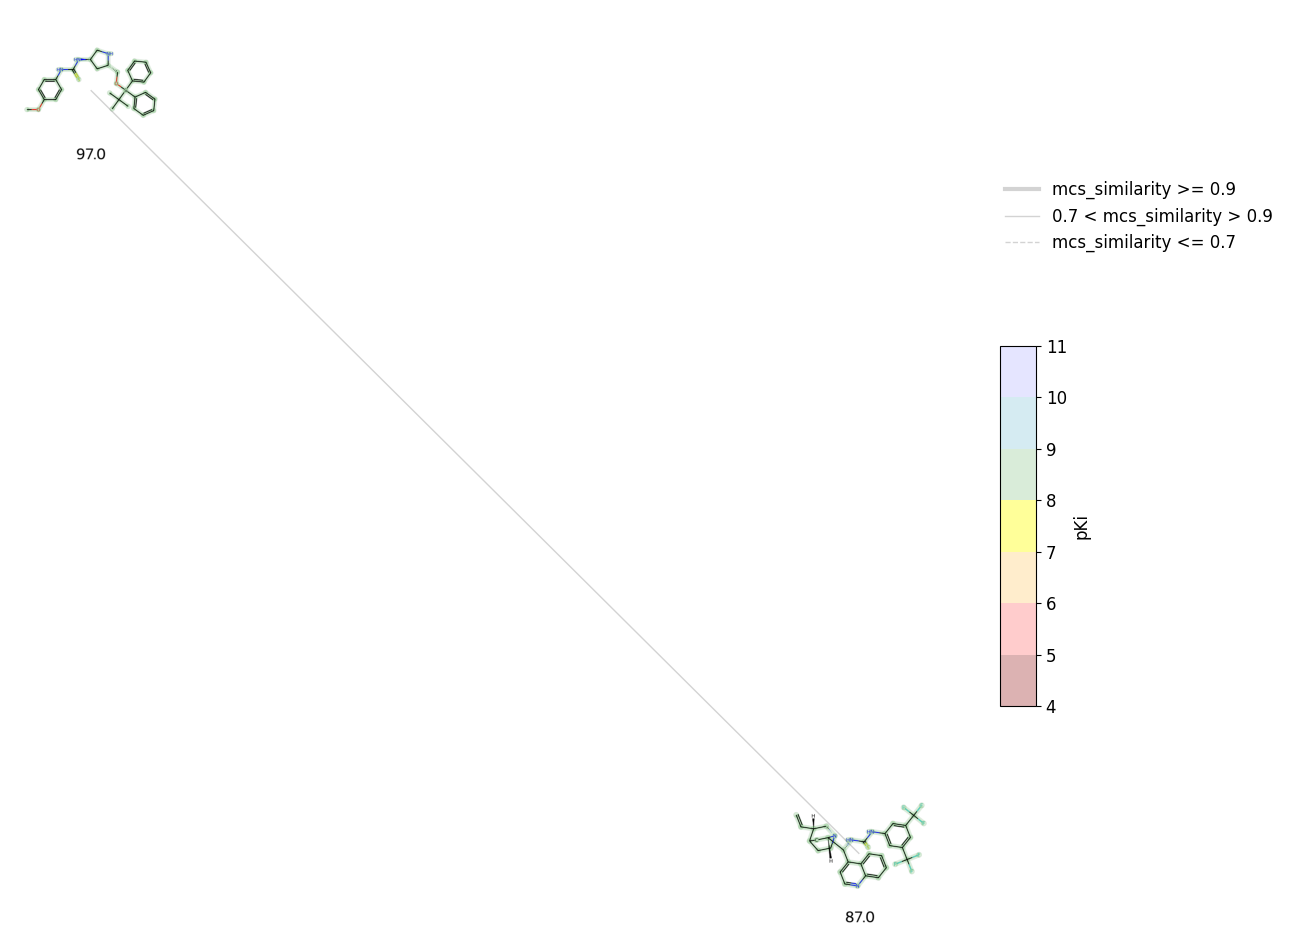

In [465]:
H2 = connected_graphs1[2]

thick = [(u, v) for (u, v, d) in H2.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H2.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H2.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(H2, seed=42)
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(H2, pos=pos, ax=ax, edgelist=thick, width=3, edge_color="lightgrey")
nx.draw_networkx_edges(H2, pos=pos, ax=ax, edgelist=medium, width=1, edge_color="lightgrey")
nx.draw_networkx_edges(H2, pos=pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax.axis('off')

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
struct_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
struct_center = struct_size / 2.0

# Add the respective image to each node

for smi,value in H2.nodes.items():


    if 0 < value["pKi"] <= 50:
        highlight_color = "darkred"

        
    elif 50 < value["pKi"] <= 70:
        highlight_color = "red"
    elif 70 < value["pKi"] <= 85:
        highlight_color = "yellow"
    elif 85 < value["pKi"] <= 100:
        highlight_color = "green"

    else:
        highlight_color = "white"

    xf, yf = tr_figure(pos[smi])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot
    a = plt.axes([xa - struct_center, ya - struct_center, struct_size, struct_size])
    a.imshow(show_png(highlight_mol(smi,str(value["pKi"]), highlight_color)))
    a.axis("off")

# add legends

ax2 = fig.add_axes([0.95, 0.3, 0.03, 0.3]) # distance left, distance up, width size, height size
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

# define our modified colors for the color bar scale
darkred_bar = (0.55, 0.0, 0.0, 0.3)       
red_bar = (1.0, 0.0, 0.0, 0.2)    
orange_bar = (1.0, 0.65, 0.0, 0.2)        
yellow_bar = (1.0, 1.0, 0.0, 0.4)        
green_bar = (0.0, 0.50, 0.0, 0.15)        
lightblue_bar = (0.68, 0.85, 0.90, 0.5)   
blue_bar = (0.0, 0.0, 1.0, 0.1)    

cmap = (colors.ListedColormap([darkred_bar,red_bar,orange_bar,yellow_bar,
                               green_bar,lightblue_bar,blue_bar]))
bounds = [4, 5, 6, 7, 8, 9, 10, 11]
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='neither',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',

)
cbar.ax.tick_params(labelsize=12)
ax2.set_ylabel('pKi', size=12)

ax3 = fig.add_axes([1.16, 0.45, 0.03, 0.3]) # distance left, distance up, width size, height size
ax3.axis("off")
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="lightgray", lw=3),
                Line2D([0], [0], color="lightgrey", lw=1),
                Line2D([0], [0], color="lightgrey", lw=1, linestyle='dashed',)]

ax3.legend(custom_lines, ['mcs_similarity >= 0.9', '0.7 < mcs_similarity > 0.9', 'mcs_similarity <= 0.7'],
           loc='best', prop={'size': 12}, fancybox=True, framealpha=0)
plt.show()

In [484]:
node_coefficients = nx.clustering(G1, weight="weight")

# Get mean 
coefficients = []
for key,value in node_coefficients.items():
    coefficients.append(value)
    
avg_clustering_coefficient = np.mean(coefficients)
round(avg_clustering_coefficient,3)

0.522

In [485]:
round(nx.degree_assortativity_coefficient(G1,weight="weight"),3)

0.584

In [486]:

from networkx.algorithms.community import greedy_modularity_communities
communities = greedy_modularity_communities(G1, weight="weight") # added in similarity threshold as a weight

In [487]:
len(communities)

49

In [488]:
import matplotlib
cmap = matplotlib.cm.get_cmap('tab20')

color_intervals = np.linspace(0,1,len(communities)) # for 13 colors
colors_tab = []
for value in color_intervals:
    colors_tab.append(cmap(value))

/tmp/ipykernel_124256/1832340488.py:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [489]:
community_color_map = []

for node in G1.nodes:
     for idx,community in enumerate(communities):
        if node in community:
            #print(node,idx)
            community_color_map.append(colors_tab[idx])

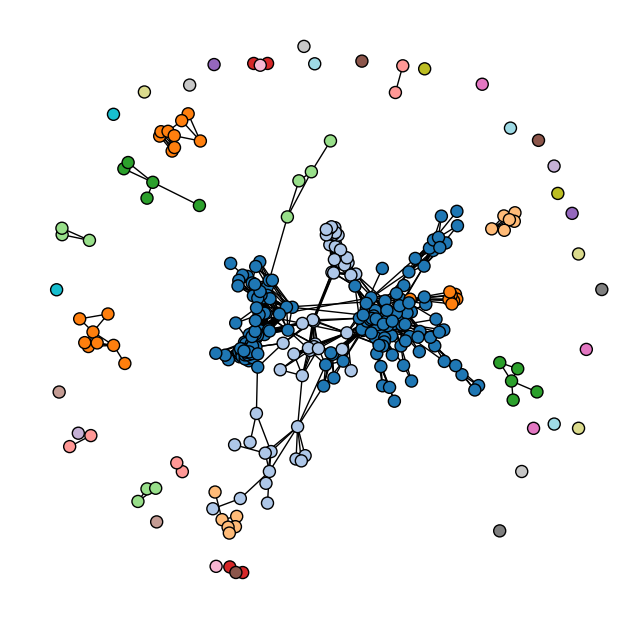

In [490]:
# plot nodes with color as community
pos = nx.spring_layout(G1, k=0.1, seed=40) # added a seed for layout reproducibility
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(G1,pos, node_color=community_color_map, edgecolors="black", node_size=75)
plt.axis("off")
plt.savefig("Figure-06--mcs_communities.png", bbox_inches='tight')
plt.show()  # how cool is that!

In [491]:
import networkx.algorithms.community as nx_comm
round(nx_comm.modularity(G1,communities),3)

0.647

[65.92142946758477, 46.5, 92.0, 83.5, 85.6, 94.0, 57.0, 69.0171130952381, 62.0, 88.0, 51.5, 78.0, 11.0, 79.85, 7.0, 75.0, 60.0]
[298, 2, 2, 2, 1, 1, 1, 16, 1, 1, 1, 2, 1, 5, 1, 1, 1]
[99.0, 81.0, 97.0, 99.0, 85.6, 94.0, 57.0, 99.0, 62.0, 88.0, 51.5, 93.0, 11.0, 97.0, 7.0, 75.0, 60.0]


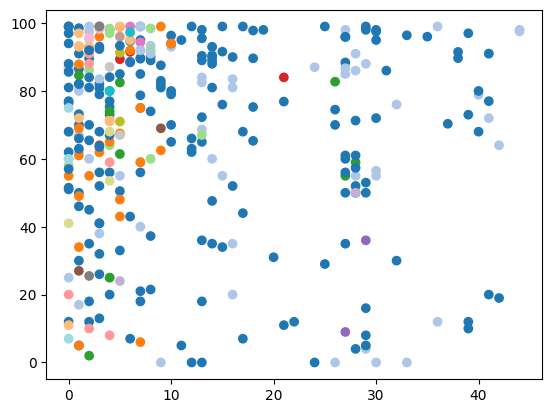

In [492]:
mean_ee = []
size = []
all_values_percom=[]
all_values = []
max_ee = []
edges = []
for i in range(len(connected_graphs1)):
    sub_values = []
    for smi,value in connected_graphs1[i].nodes.items():
        sub_values.append(value["pKi"])
        edges.append(len(G1.edges([smi])))
        all_values.append(value["pKi"])
    mean_ee.append(np.mean(sub_values))
    max_ee.append(np.max(sub_values))
    size.append(len(sub_values))
    all_values_percom.append(sub_values)
print(mean_ee)
print(size)
print(max_ee)
#plt.hist(edges)
plt.scatter(edges, all_values, color=community_color_map)

(array([130.,  58.,  36.,  25.,   9.,   9.,  43.,   6.,   9.,  12.]),
 array([ 0. ,  4.4,  8.8, 13.2, 17.6, 22. , 26.4, 30.8, 35.2, 39.6, 44. ]),
 <BarContainer object of 10 artists>)

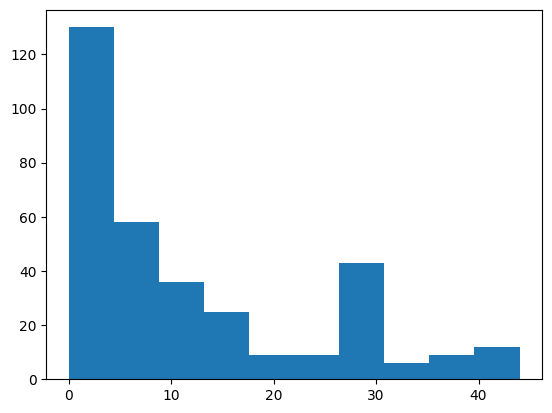

In [493]:
plt.hist( edges)

[63.26269862893239, 64.31092382469338, 67.90254250580338, 68.4069200621217, 58.435466494290026]
[77, 63, 46, 41, 14]
[99.0, 99.0, 99.0, 99.0, 89.3529411764706]
[21.506493506493506, 21.65714285714286, 17.698924731182796, 16.643171806167402, 15.850622406639005]
[0.27930511047394163, 0.3437641723356009, 0.3847592332865825, 0.4059310196626196, 1.1321873147599288]
[63.26269862893239, 64.31092382469338, 67.90254250580338, 68.4069200621217, 58.435466494290026]


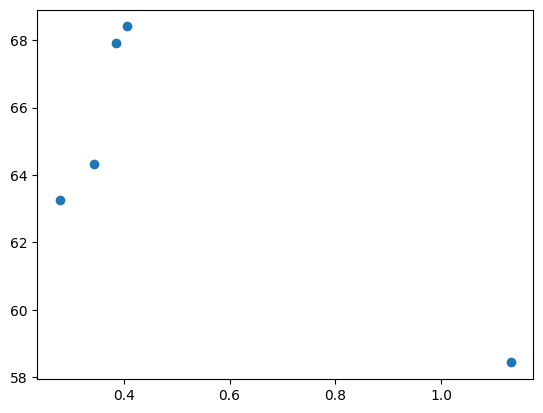

In [496]:
mean_ee = []
size = []
all_values=[]
max_ee = []
edg=[]
connect_ratio=[]
com_edges=[]
for comuinty in communities:
    sub_values = []
    edges=[]
    if len(comuinty)>10:
        for value in comuinty:
            sub_values.append(G1.nodes[value]["pKi"])
            edg.append(G1.degree(value))

        com_edges.append(np.mean(edg))
        mean_ee.append(np.mean(sub_values))
        max_ee.append(np.max(sub_values))
        size.append(len(sub_values))
        all_values.append(sub_values)
        connect_ratio.append(np.mean(edg)/len(sub_values))
print(mean_ee)
print(size)
print(max_ee)
print(com_edges)
print(connect_ratio)
print(mean_ee)
plt.scatter(connect_ratio,mean_ee)

In [229]:
degree_centrality = nx.degree_centrality(G1)
hubs = [node for node, centrality in degree_centrality.items() if centrality >= 0.5]
for hub in hubs:
    print(hub, G1.nodes[edge[0][1]]["pKi"])

(array([9., 2., 2., 4., 3., 0., 5., 3., 0., 2.]),
 array([ 1., 10., 19., 28., 37., 46., 55., 64., 73., 82., 91.]),
 <BarContainer object of 10 artists>)

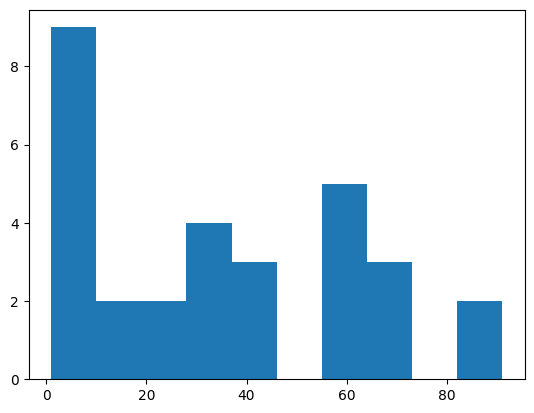

In [254]:
betweenness_centrality = nx.betweenness_centrality(G1)
hubs = [node for node, centrality in betweenness_centrality.items() if centrality >= 0.15]
for hub in hubs:
    print(hub, node_data[hub]["Ki"], G1.degree([hub][0]))
slected_data =  dict((n,d["pKi"]) for n,d in G1.nodes().items() if d["pKi"]>=98)
degrees = []
H = nx.induced_subgraph(G1, slected_data)
betweenes= []

#plt.plot(nx.degree_histogram(H))
for data in slected_data:
    degrees.append(G1.degree(data))
    #degrees.append(G1.betweenness_centrality(data))
    betweenes.append(betweenness_centrality[data])
degrees
plt.hist(degrees)

{'pKi': 44.0} {'pKi': 97.8125}
48 42
{'pKi': 98.0} {'pKi': 0.0}
31 23
{'pKi': 98.0} {'pKi': 18.0}
31 22
{'pKi': 97.8125} {'pKi': 47.6}
42 35
{'pKi': 61.0} {'pKi': 0.0}
72 79
{'pKi': 0.0} {'pKi': 84.0}
59 47
{'pKi': 35.0} {'pKi': 93.0}
20 19
{'pKi': 35.0} {'pKi': 90.0}
20 27
{'pKi': 98.0} {'pKi': 12.0}
75 73
{'pKi': 98.0} {'pKi': 0.0}
75 79
{'pKi': 98.0} {'pKi': 12.0}
75 57
{'pKi': 12.0} {'pKi': 70.33333333333333}
73 55
{'pKi': 12.0} {'pKi': 96.0}
73 60
{'pKi': 12.0} {'pKi': 99.0}
73 73
{'pKi': 12.0} {'pKi': 76.0}
73 76
{'pKi': 12.0} {'pKi': 97.55555555555556}
73 75
{'pKi': 99.0} {'pKi': 11.0}
73 50
{'pKi': 99.0} {'pKi': 0.0}
73 79
{'pKi': 76.0} {'pKi': 0.0}
76 79
{'pKi': 0.0} {'pKi': 97.55555555555556}
79 75
{'pKi': 0.0} {'pKi': 91.5}
79 55
{'pKi': 0.0} {'pKi': 89.66666666666667}
79 55
{'pKi': 97.55555555555556} {'pKi': 12.0}
75 57
{'pKi': 93.33333333333333} {'pKi': 40.0}
38 33
{'pKi': 84.0} {'pKi': 25.0}
47 26
{'pKi': 86.0} {'pKi': 10.0}
52 54
{'pKi': 52.0} {'pKi': 0.0}
25 23
{'pKi': 

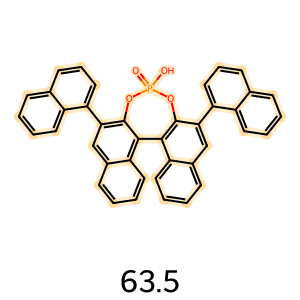

In [231]:
sharp_edges = []
for edge in G1.edges().items():
    if edge[1]['weight'] >0.9:
        if abs(G1.nodes[edge[0][0]]["pKi"] - G1.nodes[edge[0][1]]["pKi"])>50:
            
            print(G1.nodes[edge[0][0]],G1.nodes[edge[0][1]])
            #print(edge[1]['weight'])
            print(G1.degree(edge[0][0]), G1.degree(edge[0][1]))
            sharp_edges.append([edge[0][0],edge[0][1],G1.nodes[edge[0][1]]["pKi"]])
            #print(betweenness_centrality[edge[0][0]], betweenness_centrality[edge[0][1]])
show_png(highlight_mol(edge[0][0],str(G1.nodes[edge[0][0]]["pKi"]), 'orange'))
show_png(highlight_mol(edge[0][1],str(G1.nodes[edge[0][1]]["pKi"]), 'orange'))